In [1]:
import torch
import numpy as np
import copy
import matplotlib.pyplot as plt

In [ ]:
inputs = torch.load('train_in.pt')
print(torch.mean(inputs, dim=(0, 2)))
for i in range(15):
    inputs = (inputs - torch.mean(inputs, dim=(0, 2)).view(1, -1, 1))
    print(torch.mean(inputs, dim=(0, 2)))
inputs = inputs / torch.std(inputs, dim=(0,2)).view(1, -1, 1)
print(torch.mean(inputs, dim=(0, 2)))
outputs = torch.load('train_out.pt')
np_ins = inputs.numpy()
np_outs = outputs.numpy()

inny = inputs[:, 0, :]
print(torch.mean(inny))
inny = (torch.mean(inny - torch.mean(inny)))
print(torch.mean(inny))
inny = (torch.mean(inny - torch.mean(inny)))
print(torch.mean(inny))
inny = (torch.mean(inny - torch.mean(inny)))
print(torch.mean(inny))

tensor([0.5392, 0.5340, 0.7343, 1.1033, 0.4694])
tensor([0.1277, 0.1307, 0.1938, 0.2471, 0.0586])
tensor([ 0.0348,  0.0378,  0.0350,  0.0496, -0.0022])


In [23]:
# BASIC STATS #

Output Mean: -0.283
Output Variance: 3.553


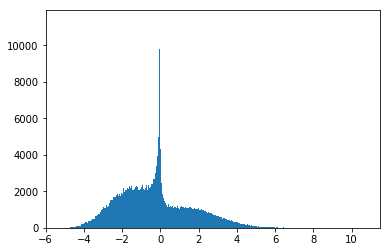

In [24]:
# Outputs
print('Output Mean: %.3f' % torch.mean(outputs))
print('Output Variance: %.3f' % torch.std(outputs)**2)
outputs_histogram = plt.hist(np_outs, 1000)

Input Mean: 0.210
Input Variance: 1.004


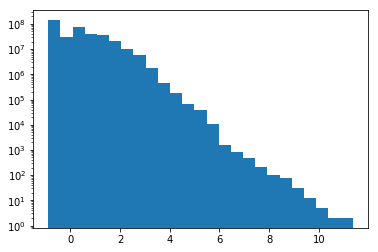

In [25]:
# Inputs

# Overall
print('Input Mean: %.3f' % torch.mean(inputs))
print('Input Variance: %.3f' % torch.std(inputs)**2)
inputs_histogram = plt.hist(np_ins.reshape(-1), 25, log=True)

Histone 1 Input Mean: 0.226
Histone 1 Input Variance: 1.000
Histone 2 Input Mean: 0.249
Histone 2 Input Variance: 1.000
Histone 3 Input Mean: 0.280
Histone 3 Input Variance: 1.000
Histone 4 Input Mean: 0.205
Histone 4 Input Variance: 1.000
Histone 5 Input Mean: 0.097
Histone 5 Input Variance: 1.000


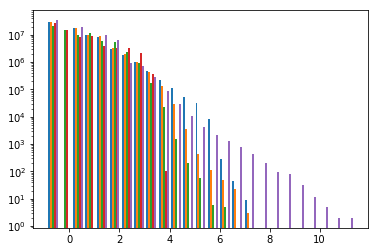

In [26]:
# Per Histone
for i_histone in range(5):
    print('Histone %d Input Mean: %.3f' % (i_histone+1, torch.mean(inputs[:, i_histone])))
    print('Histone %d Input Variance: %.3f' % (i_histone+1, torch.std(inputs[:, i_histone])**2))
histogram = plt.hist([np_ins[:,i].reshape(-1) for i in range(5)], 25, log=True)

Mean:


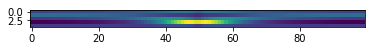

Variance:


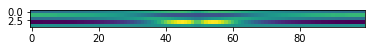

This shows that almost all of the "action" is in a very specific region of one histone modification.


In [7]:
# Per Cell
print('Mean:')
mean_input = plt.imshow(np.mean(np_ins, axis=0))
plt.show()
print('Variance:')
variance_input = plt.imshow(np.std(np_ins, axis=0)**2)
plt.show()
print('This shows that almost all of the "action" is in a very specific region of one histone modification.')

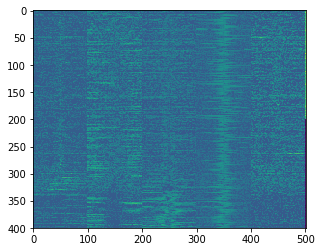

Note how similar the most positive and most negative examples are.


In [8]:
pos_inds = np_outs > 4
neg_inds = np_outs < -4
pos_examples = np.concatenate([np_ins.reshape(-1, 500)[pos_inds][:200], np_outs[pos_inds][:200].reshape(-1, 1)], axis=1)
neg_examples = np.concatenate([np_ins.reshape(-1, 500)[neg_inds][:200], np_outs[neg_inds][:200].reshape(-1, 1)], axis=1)
plt.imshow(np.concatenate([pos_examples, neg_examples], axis=0))
plt.show()

print('Note how similar the most positive and most negative examples are.')

In [9]:
nph_ins = np.concatenate([np_ins[:, :3], np_ins[:, 4:]], axis=1)
print(nph_ins.shape)

print('If we take out the dominant histone we get the following:')

(720000, 4, 100)
If we take out the dominant histone we get the following:


Input Mean: 0.210
Input Variance: 1.004


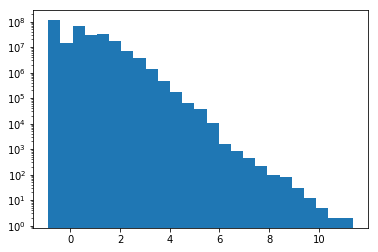

In [10]:
# Overall
print('Input Mean: %.3f' % torch.mean(inputs))
print('Input Variance: %.3f' % torch.std(inputs)**2)
inputs_histogram = plt.hist(nph_ins.reshape(-1), 25, log=True)

Mean:


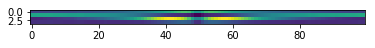

Variance:


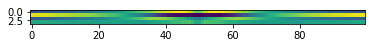

In [11]:
# Per Cell
print('Mean:')
mean_input = plt.imshow(np.mean(nph_ins, axis=0))
plt.show()
print('Variance:')
variance_input = plt.imshow(np.std(nph_ins, axis=0)**2)
plt.show()

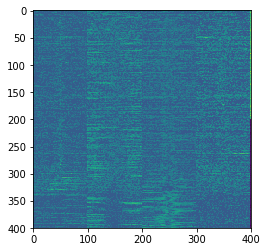

In [12]:
pos_inds = np_outs > 4
neg_inds = np_outs < -4
pos_examples = np.concatenate([nph_ins.reshape(-1, 400)[pos_inds][:200], np_outs[pos_inds][:200].reshape(-1, 1)], axis=1)
neg_examples = np.concatenate([nph_ins.reshape(-1, 400)[neg_inds][:200], np_outs[neg_inds][:200].reshape(-1, 1)], axis=1)
plt.imshow(np.concatenate([pos_examples, neg_examples], axis=0))
plt.show()

In [13]:
# Per Cell Type
num_cells = 48
cell_samples = inputs.size(0) // num_cells
cells = [(np_ins[i*cell_samples:(i+1)*cell_samples], np_outs[i*cell_samples:(i+1)*cell_samples]) for i in range(num_cells)]
print(cells[-1][0].shape)
print(cells[-1][1].shape)

(15000, 5, 100)
(15000,)


Output distribution for cell 1


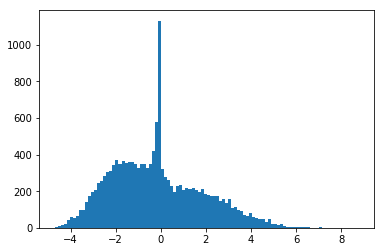

Output distribution for cell 2


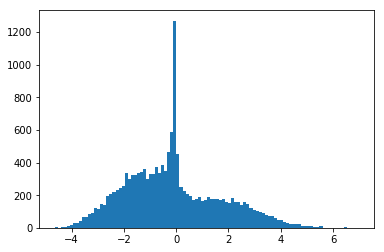

Output distribution for cell 3


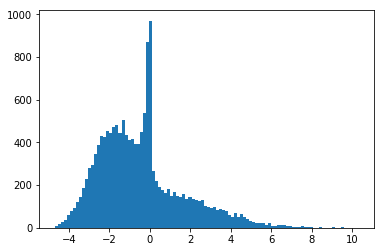

Output distribution for cell 4


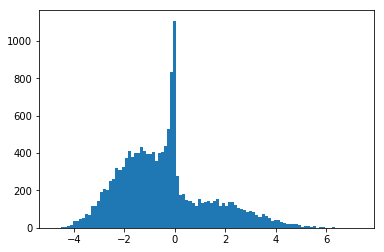

Output distribution for cell 5


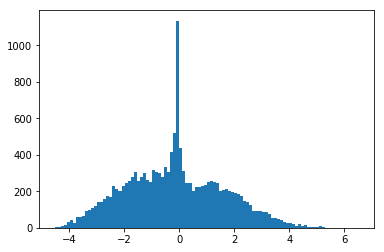

Output distribution for cell 6


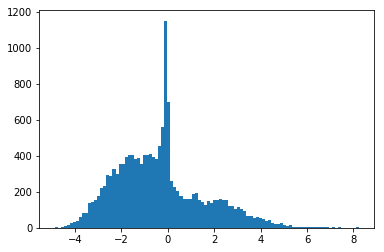

Output distribution for cell 7


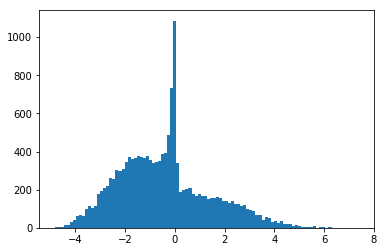

Output distribution for cell 8


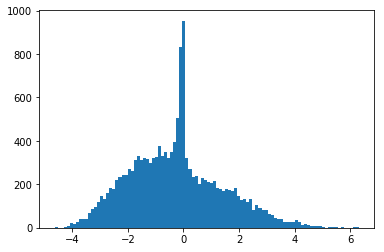

Output distribution for cell 9


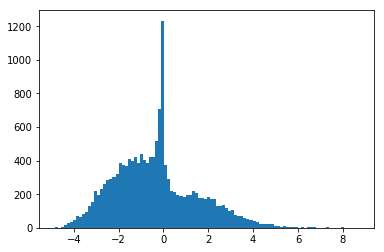

Output distribution for cell 10


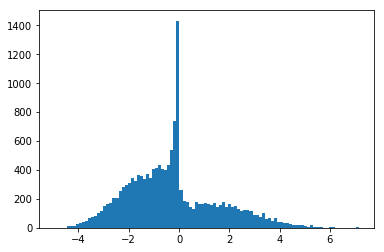

Output distribution for cell 11


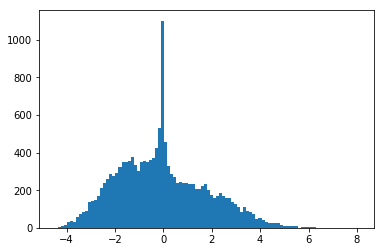

Output distribution for cell 12


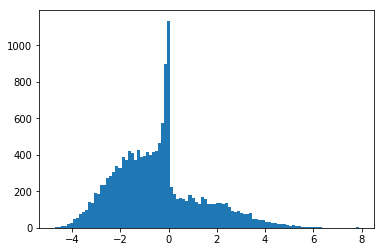

Output distribution for cell 13


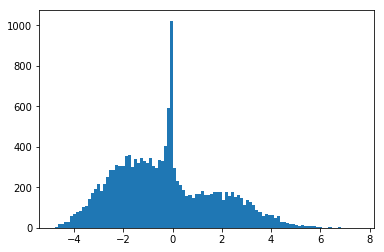

Output distribution for cell 14


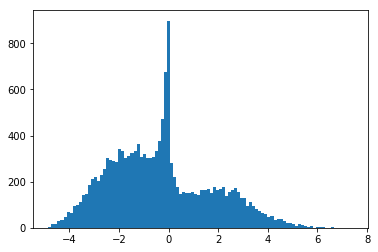

Output distribution for cell 15


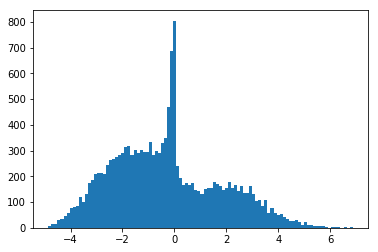

Output distribution for cell 16


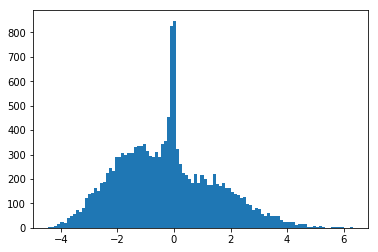

Output distribution for cell 17


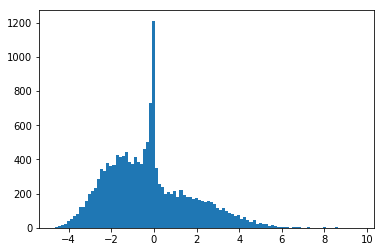

Output distribution for cell 18


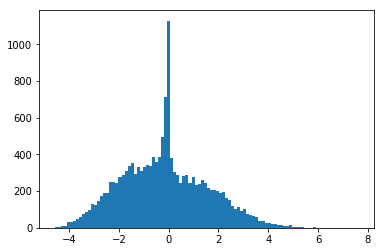

Output distribution for cell 19


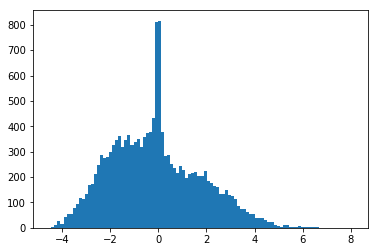

Output distribution for cell 20


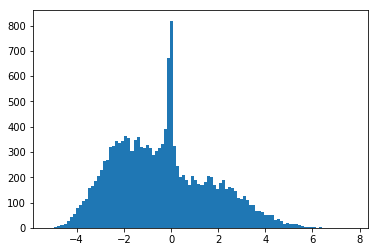

Output distribution for cell 21


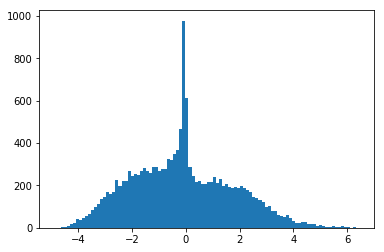

Output distribution for cell 22


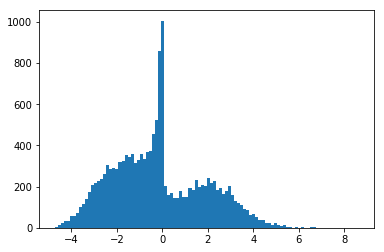

Output distribution for cell 23


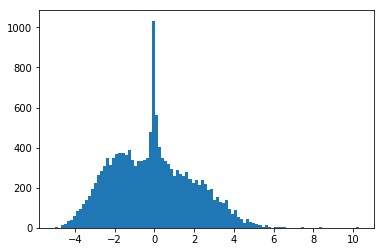

Output distribution for cell 24


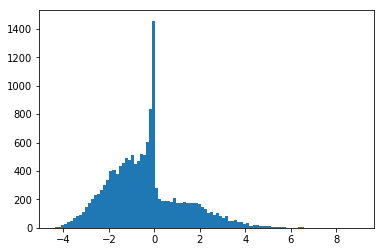

Output distribution for cell 25


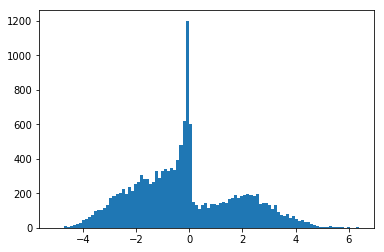

Output distribution for cell 26


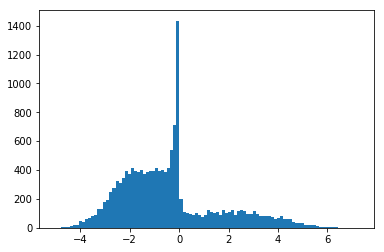

Output distribution for cell 27


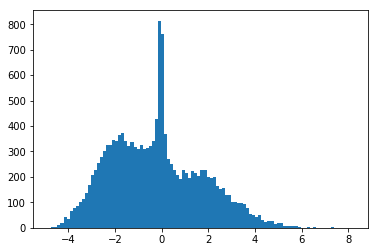

Output distribution for cell 28


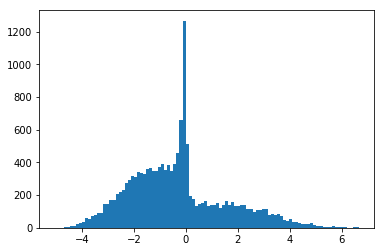

Output distribution for cell 29


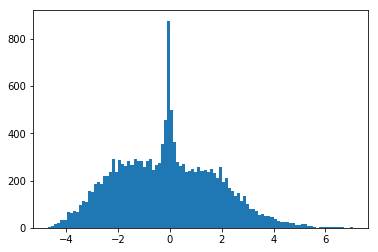

Output distribution for cell 30


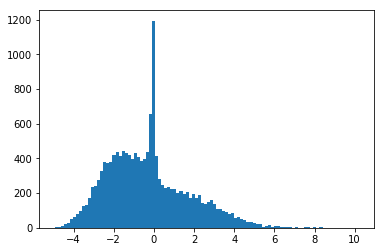

Output distribution for cell 31


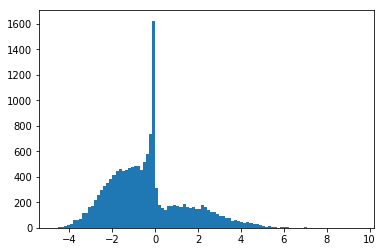

Output distribution for cell 32


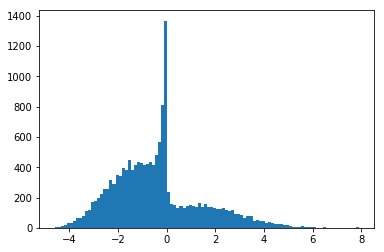

Output distribution for cell 33


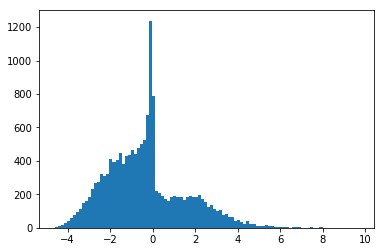

Output distribution for cell 34


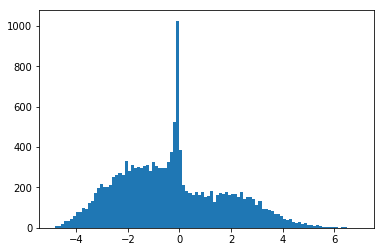

Output distribution for cell 35


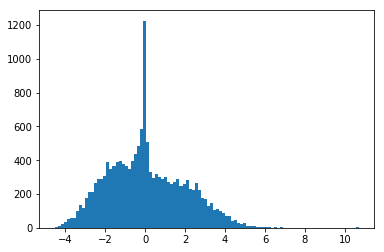

Output distribution for cell 36


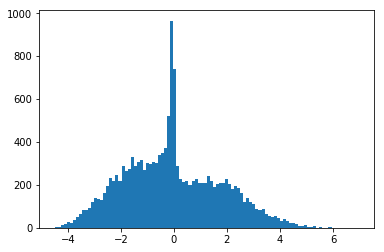

Output distribution for cell 37


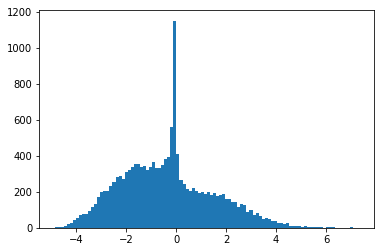

Output distribution for cell 38


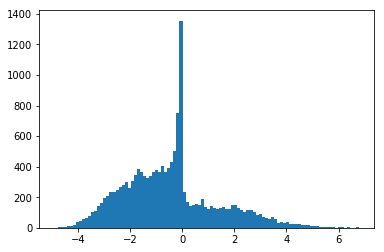

Output distribution for cell 39


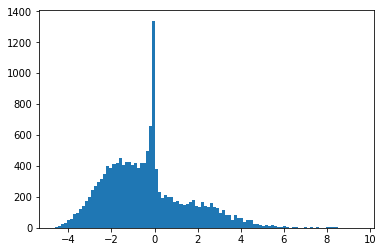

Output distribution for cell 40


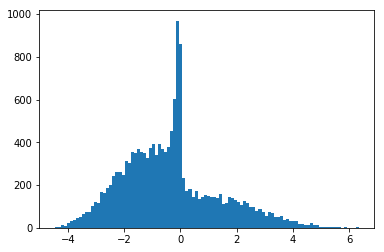

Output distribution for cell 41


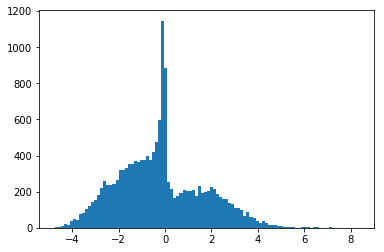

Output distribution for cell 42


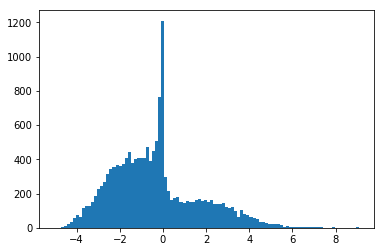

Output distribution for cell 43


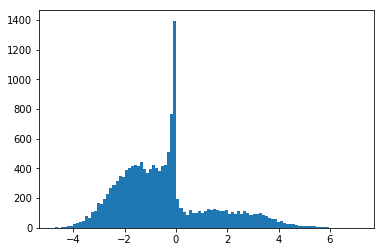

Output distribution for cell 44


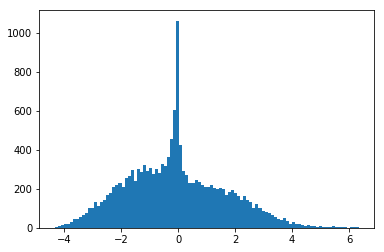

Output distribution for cell 45


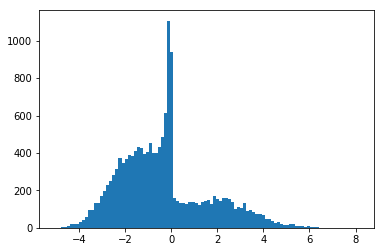

Output distribution for cell 46


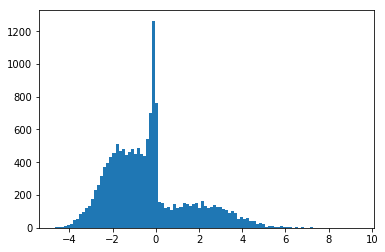

Output distribution for cell 47


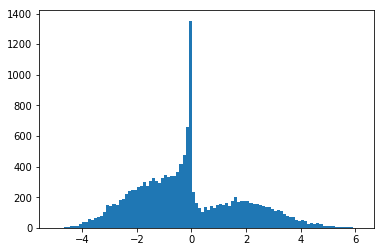

Output distribution for cell 48


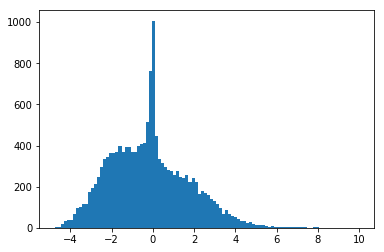

In [14]:
for i in range(num_cells):
    print('Output distribution for cell %d' % (i+1))
    plt.hist(cells[i][1], 100)
    plt.show()

Output distribution for cell 1


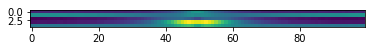

Output distribution for cell 2


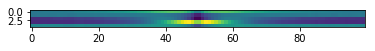

Output distribution for cell 3


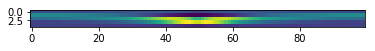

Output distribution for cell 4


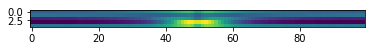

Output distribution for cell 5


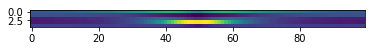

Output distribution for cell 6


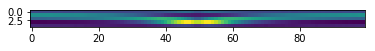

Output distribution for cell 7


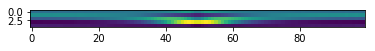

Output distribution for cell 8


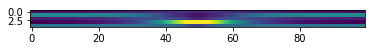

Output distribution for cell 9


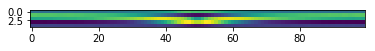

Output distribution for cell 10


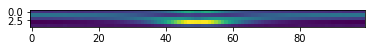

Output distribution for cell 11


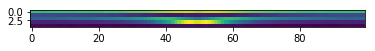

Output distribution for cell 12


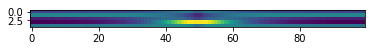

Output distribution for cell 13


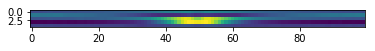

Output distribution for cell 14


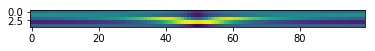

Output distribution for cell 15


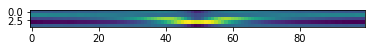

Output distribution for cell 16


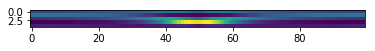

Output distribution for cell 17


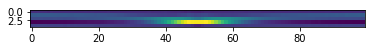

Output distribution for cell 18


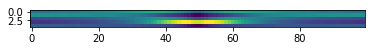

Output distribution for cell 19


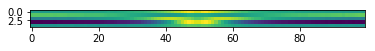

Output distribution for cell 20


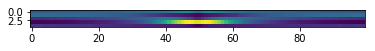

Output distribution for cell 21


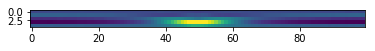

Output distribution for cell 22


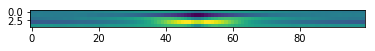

Output distribution for cell 23


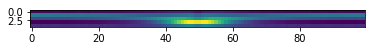

Output distribution for cell 24


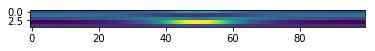

Output distribution for cell 25


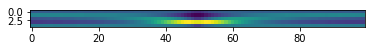

Output distribution for cell 26


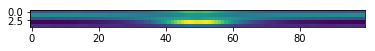

Output distribution for cell 27


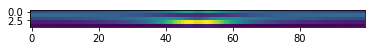

Output distribution for cell 28


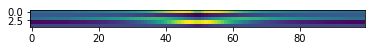

Output distribution for cell 29


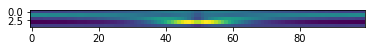

Output distribution for cell 30


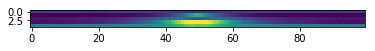

Output distribution for cell 31


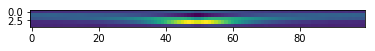

Output distribution for cell 32


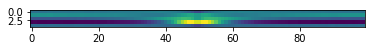

Output distribution for cell 33


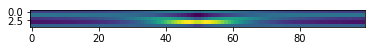

Output distribution for cell 34


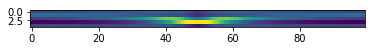

Output distribution for cell 35


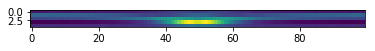

Output distribution for cell 36


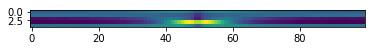

Output distribution for cell 37


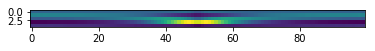

Output distribution for cell 38


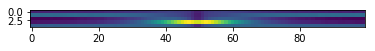

Output distribution for cell 39


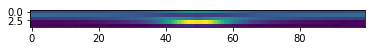

Output distribution for cell 40


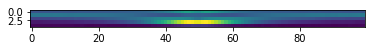

Output distribution for cell 41


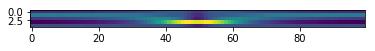

Output distribution for cell 42


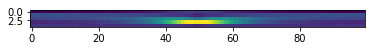

Output distribution for cell 43


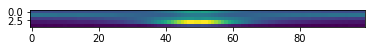

Output distribution for cell 44


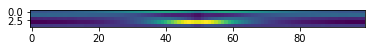

Output distribution for cell 45


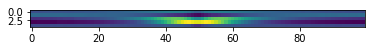

Output distribution for cell 46


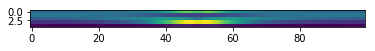

Output distribution for cell 47


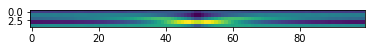

Output distribution for cell 48


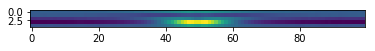

In [15]:
for i in range(num_cells):
    print('Output distribution for cell %d' % (i+1))
    plt.imshow(cells[i][0].mean(axis=0))
    plt.show()

In [16]:
# How to resample away those peaks??

What if we just resample the dataset according to the square root of the magnitude of the targets?
Output Mean: -0.288
Output Variance: 5.064
Eh, not that much better, although it is something.


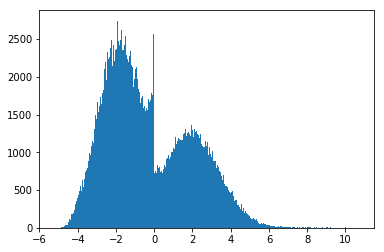

In [17]:
print('What if we just resample the dataset according to the square root of the magnitude of the targets?')

i_outs = torch.multinomial(torch.abs(outputs)**(1/2.5), outputs.size(0), replacement=True)
newouts = outputs[i_outs]

print('Output Mean: %.3f' % torch.mean(newouts))
print('Output Variance: %.3f' % torch.std(newouts)**2)
outputs_histogram = plt.hist(newouts, 1000)

print('Eh, not that much better, although it is something.')

Let's say we want to resample our data to be approximately normal:
Output Mean: -0.000
Output Variance: 3.553


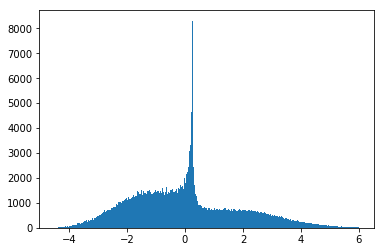

Output Mean: 0.002
Output Variance: 2.251


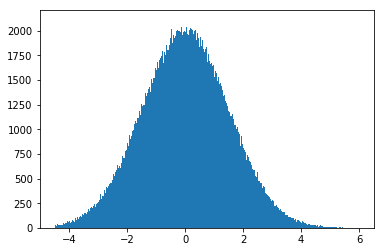

In [18]:
print("Let's say we want to resample our data to be approximately normal:")

centered_outputs = outputs - torch.mean(outputs)
normal_ = torch.randn(outputs.size(0))*1.5
#i_outs = torch.multinomial(outputs, outputs.size(0), replacement=True)
#newouts = outputs[i_outs]

print('Output Mean: %.3f' % torch.mean(centered_outputs))
print('Output Variance: %.3f' % torch.std(centered_outputs)**2)
outputs_histogram = plt.hist(centered_outputs, 1000, (-4.5, 6))
plt.show()

print('Output Mean: %.3f' % torch.mean(normal_))
print('Output Variance: %.3f' % torch.std(normal_)**2)
normal_histogram = plt.hist(normal_, 1000, (-4.5, 6))
plt.show()

To resample to normal we need the transformation distribution between our sample distribution and the normal distribution:


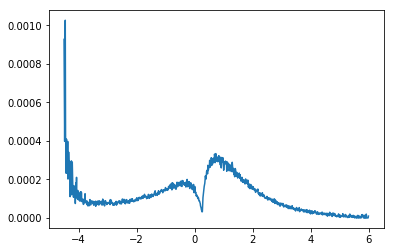

0.0012062285605654729


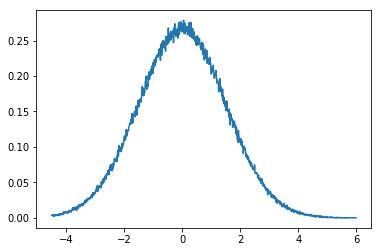

0.9999999999999999


In [19]:
print('To resample to normal we need the transformation distribution between our sample distribution and the normal distribution:')

# normal = adjust x sample
# adjust = normal / sample
new_histogram = normal_histogram[0] / (outputs_histogram[0] + 1e-6)
new_histogram = new_histogram / (np.sum(new_histogram * outputs_histogram[0]) * 0.0105)
plt.plot(normal_histogram[1][:-1], new_histogram)
plt.show()
print(np.sum(new_histogram) * 0.0105)

reconstruction = new_histogram * outputs_histogram[0]
plt.plot(normal_histogram[1][:-1], reconstruction)
plt.show()
print(np.sum(reconstruction) * 0.0105)

To actually perform the resampling, we need to create a pdf over the indices of our dataset such that when sampled it is approximately normal as above:


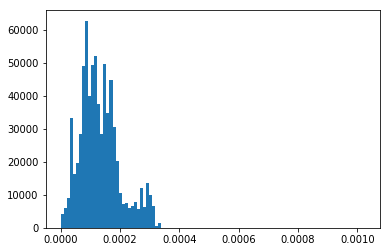

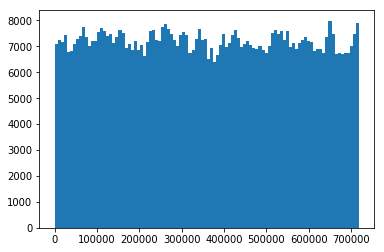

Output Mean: 0.010
Output Variance: 2.221


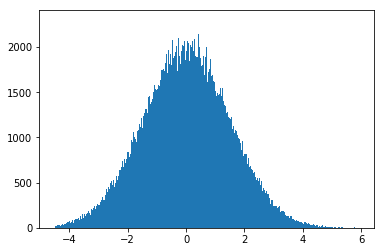

In [20]:
print('To actually perform the resampling, we need to create a pdf over the indices of our dataset such that when sampled it is approximately normal as above:')

# How to use the new histogram to sample from the sample distribution?
# have to line up the outputs for sampling?
logits = centered_outputs
log_ins = inputs
log_ins = log_ins[logits > -4.5]
logits = logits[logits > -4.5]
log_ins = log_ins[logits < 6]
logits = logits[logits < 6]
logits2 = copy.deepcopy(logits)
for idx, edges in enumerate(np.stack([normal_histogram[1][:-1], normal_histogram[1][1:]], axis=1)):
    logits2[(logits >= edges[0]) * (logits <= edges[1])] = new_histogram[idx]

plt.hist(logits2, 100)
plt.show()

'''
Idea:
sort logits, rescale i_outs to be 0 to logits.shape[0] rather than 0 to 1000, and maybe add a little noise
'''

i_outs = torch.multinomial(logits2, outputs.size(0), replacement=True)
plt.hist(i_outs, 100)
plt.show()
#resampled = torch.cat([logits[logits2 == i_out][0:1] for i_out in i_outs])
#i_outs = (i_outs * multiplier + torch.rand(i_outs.shape)*multiplier).long()
resampled = logits[i_outs]
resampled_inputs = log_ins[i_outs]


print('Output Mean: %.3f' % torch.mean(resampled.float()))
print('Output Variance: %.3f' % torch.std(resampled.float())**2)
outputs_histogram = plt.hist(resampled.numpy(), 1000)

In [21]:
print('Save that resampled data!')

torch.save(resampled, 'resampled_out.pt')
torch.save(resampled_inputs, 'resampled_in.pt')

Save that resampled data!
